# List 8

## Dirichlet multinomial model


### Knowledge & Skills:
- likelihood
- apriori
- aposteriori
- maximum likelihood estimate
- maximum aposteriori estimate
- online (sequential) and batch learnig for Dirichlet-multinomial model
- [Book for help](https://github.com/jonesgithub/book-1/blob/master/ML%20Machine%20Learning-A%20Probabilistic%20Perspective.pdf)

In [1]:
# !pip install spacy

In [2]:
import math
import operator
import numpy as np
from scipy.stats import dirichlet
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.tri as tri
import spacy


In [3]:
corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
midpoints = [(corners[(i + 1) % 3] + corners[(i + 2) % 3]) / 2.0 for i in range(3)]

def xy2bc(xy, tol=1.e-3):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    s = [(corners[i] - midpoints[i]).dot(xy - midpoints[i]) / 0.75 for i in range(3)]
    x = np.clip(s, tol, 1.0 - tol)
    norm = np.sum(x)
    return x / norm

def drawPDF(i, alpha, nlevels=50, subdiv=4, **kwargs):
    fig = plt.subplot(1, 3, i)
    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = np.array([xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)])
    pvals = [dirichlet.pdf(val, alpha) for val in pvals]

    plt.tricontourf(trimesh, pvals, nlevels, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')

def results_validation(max, theta):
    arra = [0, 0, 0]
    for x in range(1, max):
    
        value = np.random.multinomial(1, theta).argmax()
        if value == 0:
            arra[0] = arra[0] + 1
        elif value == 1:
            arra[1] = arra[1] + 1
        elif value == 2:
            arra[2] = arra[2] + 1

    print("Test Results: \t\t{}".format(arra))
    print("Probability: \t\t{}".format(arra / np.asarray(arra).sum()))

def likelihood(priorTheta, X, K):
    x = [(priorTheta[i] ** X[i]) for i in range(K)]
    likelihood = np.multiply.reduce(x)
    return likelihood

def prior_dirichlet(x, alpha):
    prior = dirichlet.pdf(x, alpha)
    return prior

Alpha Values Test
============

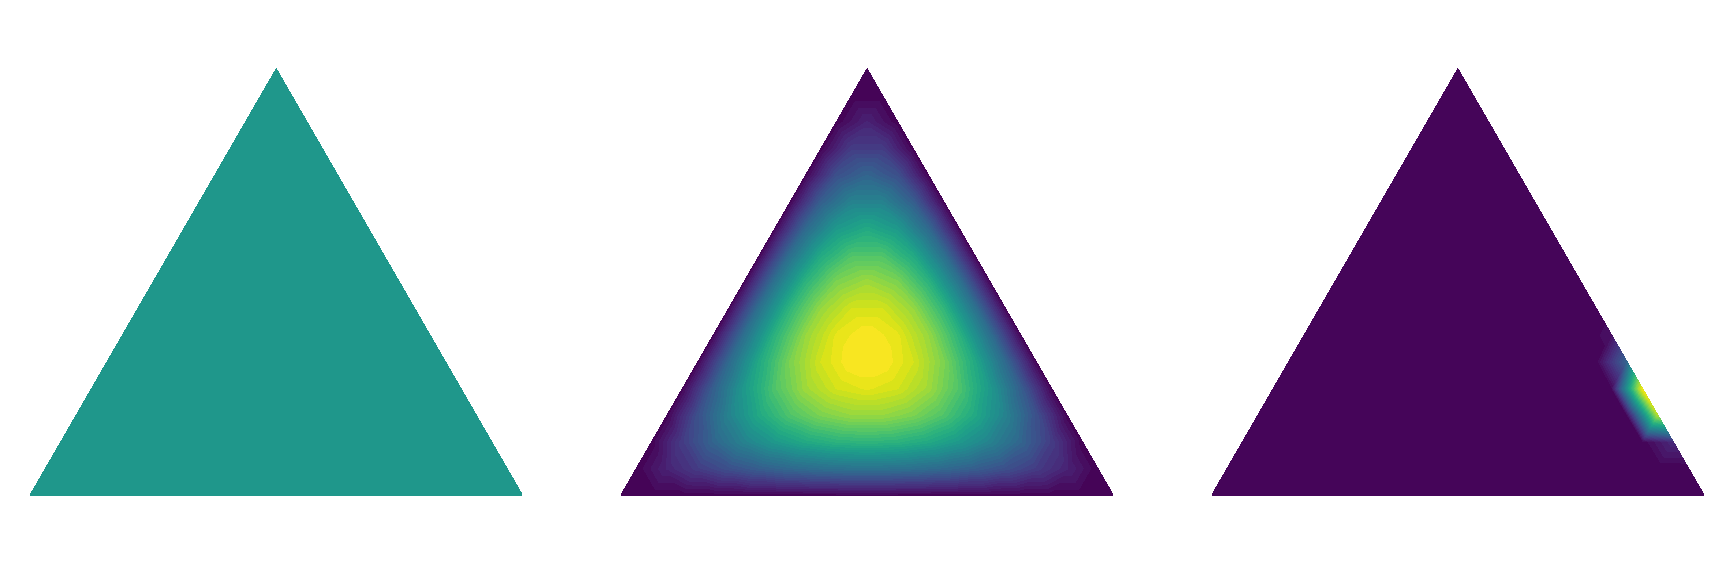

In [4]:
plt.figure(figsize=(30, 10))

alpha_1 = [1, 1, 1]
alpha_2 = [2, 2, 2]
alpha_3 = [1, 50, 15]

drawPDF(1, alpha_1)
drawPDF(2, alpha_2)
drawPDF(3, alpha_3)

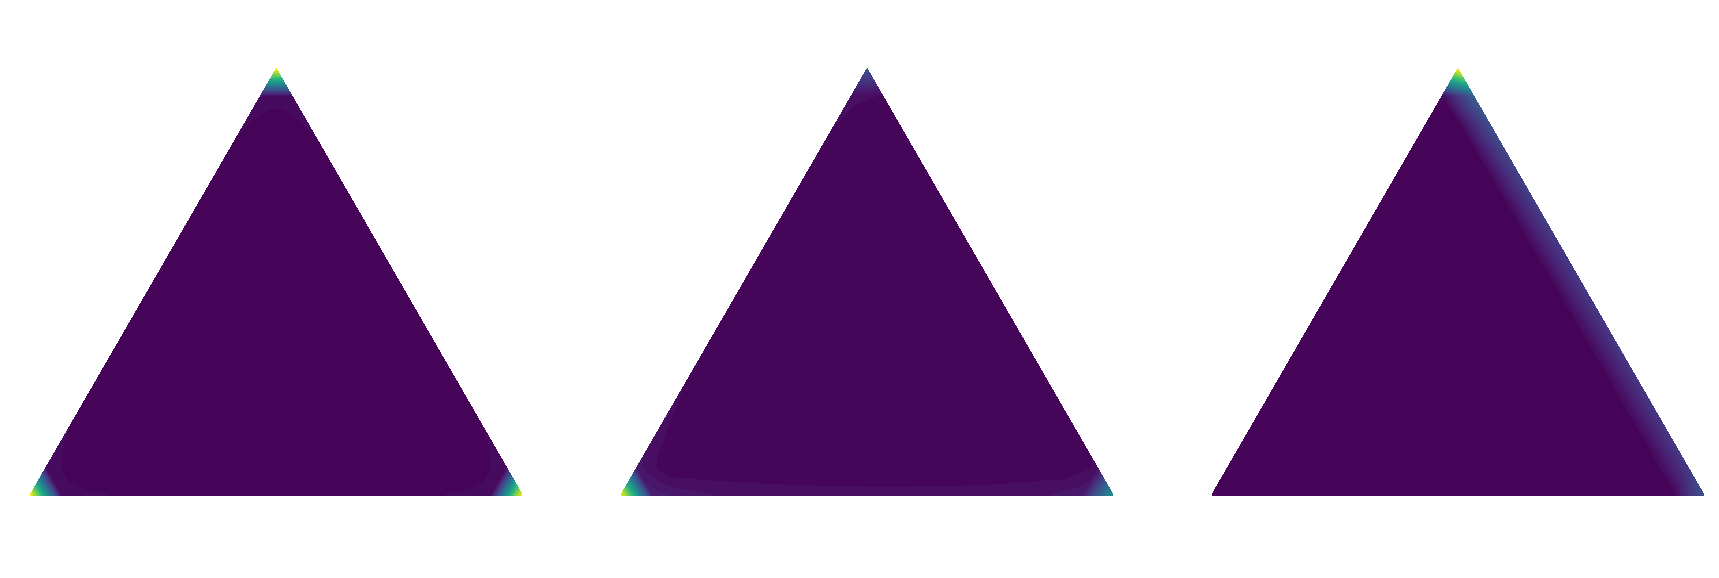

In [5]:
plt.figure(figsize=(30, 10))

alpha_4 = [0.2, 0.2, 0.2]
alpha_5 = [0.5, 0.4, 0.3]
alpha_6 = [0.1, 0.7, 0.9]

drawPDF(1, alpha_4)
drawPDF(2, alpha_5)
drawPDF(3, alpha_6)

Exercise 1
============

**Implement a Dirichlet-multinomial model for dice tossing problem:**
- likelihood as in the lecture
- prior as in the lecture
- use all required pdfs from scipy

Quantiles:	[4, 1, 5]
Alpha:		[10, 10, 10]
Theta:		[ 0.33333333  0.33333333  0.33333333]
Likelihood:	1.6935087808430275e-05
Prior:		0.09473701190553521


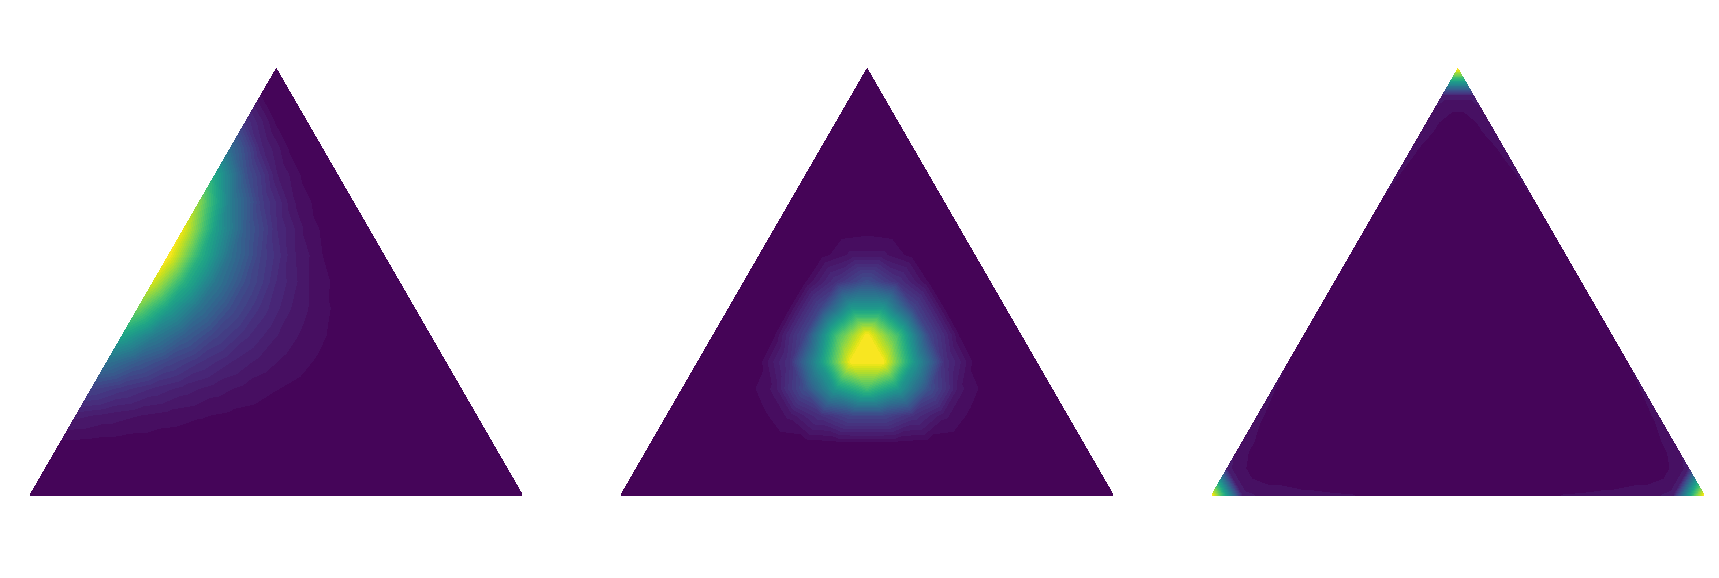

In [6]:
plt.figure(figsize=(30, 10))

N = 10
theta = (0.15, 0.7, 0.15)
K = len(theta)
X = [4, 1, 5]          # Quantiles
Xi = [0.4, 0.1, 0.5]   # Quantiles
alpha = [10, 10, 10]   # The concentration parameters. The number of entries determines the dimensionality of the distribution.

theta = alpha / np.sum(alpha)

print("Quantiles:\t{}".format(X))
drawPDF(1, X)

print("Alpha:\t\t{}".format(alpha))
drawPDF(2, alpha)

print("Theta:\t\t{}".format(theta))
drawPDF(3, theta)

likelihood = likelihood(theta, X, K)
print("Likelihood:\t{}".format(likelihood))

prior = prior_dirichlet(Xi, alpha)
print("Prior:\t\t{}".format(prior))

Exercise 2
============

**Implement a method for posterior predictive distribution of a future observation:**
- appropriate calulation of posterior predictive
- write example demonstrating prediction

Posterior:		0.4241244636687715


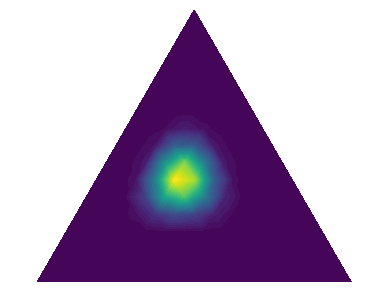

In [7]:
plt.figure(figsize=(20, 5))

posterior_values = np.asarray(alpha) + np.asarray(X)


post = prior_dirichlet(Xi, posterior_values)
print("Posterior:\t\t{}".format(post))

drawPDF(1, posterior_values)

Theta's MAP:		[0.34999999999999998, 0.27500000000000002, 0.375]
Predicted Next Value:	2
Test Results: 		[35224, 27497, 37278]
Probability: 		[ 0.35224352  0.27497275  0.37278373]


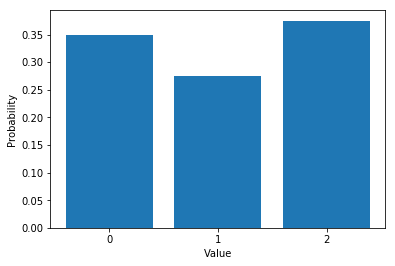

In [8]:
alpha0 = np.sum(alpha)
getMAP = lambda i: ((alpha[i] + X[i]) / (alpha0 + N))
MAP = [getMAP(i) for i in range(K)]
print("Theta's MAP:\t\t{}".format(MAP))

ind = range(K)
plt.bar(ind, MAP)
plt.xticks(ind)
plt.xlabel("Value")
plt.ylabel("Probability")

print("Predicted Next Value:\t{}".format(np.asarray(MAP).argmax()))

results_validation(100000, MAP)

Exercise 3
==================

**Implement prediction mechanism for next word in a text using your model:**
- write apropriate methods for importing 3 sources of textual data: prose, poetry, lyrics (aquire apropriate data in eng. firstly) 
- for each of them perform simple lematization and stop word elimination ([StackOverflow](https://stackoverflow.com/questions/38763007/how-to-use-spacy-lemmatizer-to-get-a-word-into-basic-form))
- provide fair train/test data mechanism for next 'word prediction'
- test model on all 3 data types with and without lemmatization, present the results on single chart (choose most appropriate for your case e.g. from seaborn)

In [9]:
import collections as clt
import spacy

def read_data(x):
    if x == 1:
        text = "prose"
    elif x == 2:
        text = "poetry"
    else:
        text = "lyrics"
    train_path = "Data/Texts/" + text + "_train.txt"
    test_path = "Data/Texts/" + text + "_test.txt"
    
    with open(train_path, 'r') as myfile:
        train = myfile.read()
    with open(test_path, 'r') as myfile:
        test = myfile.read()    
    return train.lower(), test.lower()

def prepare_lematization():
    nlp = spacy.load('en')

    nlp.vocab["."].is_stop = True
    nlp.vocab[","].is_stop = True
    nlp.vocab[";"].is_stop = True
    nlp.vocab[":"].is_stop = True
    nlp.vocab["-"].is_stop = True
    nlp.vocab["\n\n"].is_stop = True
    nlp.vocab["\""].is_stop = True
    nlp.vocab["a"].is_stop = True
    nlp.vocab["by"].is_stop = True
    nlp.vocab["is"].is_stop = True
    nlp.vocab["("].is_stop = True
    nlp.vocab[")"].is_stop = True
    nlp.vocab["?"].is_stop = True
    nlp.vocab['\n'].is_stop = True
    return nlp

def lematization(data, nlp):
    lematization = list(nlp(data))
    lematized = []
    for lem in lematization:
        if not lem.is_stop:
            lematized.append(lem.lemma_)
    return lematized

def plotStats(y1, y2, labels):

    plt.style.use('ggplot')

    fig, ax = plt.subplots(figsize=(20, 10))

    ax.set_ylabel('Correct predictions')

    # bar graphs
    x = np.arange(len(labels))

    width = 0.25
    ax.bar(x, y1, width, label='With Lematization')
    ax.bar(x + width, y2, width,
            color=list(plt.rcParams['axes.prop_cycle'])[2]['color'], label='Without Lematization')
    ax.set_xticks(x + width)
    ax.set_xticklabels(labels)
    ax.legend()

    plt.show()
    
def get_train_test(isLematiozation, train, test):
    if isLematiozation == 1:
        nlp = prepare_lematization()
        train = lematization(train, nlp)
        test = lematization(test, nlp)
    else:
        train = train.split()
        test = test.split()
    return train, test

In [10]:
def train_data(data):
    Counts = clt.Counter(data)
    WordsSum = 0
    Words = []
    WordsIncidence = []
    
    for key in Counts:
        WordsSum += Counts[key]
        Words.append(key)
        WordsIncidence.append(Counts[key])
    
    K = len(WordsIncidence)
    
    return WordsSum, Words, WordsIncidence, K

def main(isLematiozation, dataToAnalize):

    wordsSum = 0
    words = []
    positivePrediction = 0
    negativePrediction = 0
    
    train, test = read_data(dataToAnalize)
    train, test = get_train_test(isLematiozation, train, test)

    NjPrim, trainWords, NjArray, trainWordsAmt = train_data(train)

    alpha = 1
    alphaSum = 0
    for i in range(0, trainWordsAmt):
        alphaSum += alpha
    
    for index, word in enumerate(test):
        p = []
        
        for Nj in NjArray:
            p.append((alpha + Nj) / (alphaSum + NjPrim))
            
        va = np.asarray(p).argmax()
        if(index == len(test) - 1):
            break
        if trainWords[va] == test[index + 1]:
            positivePrediction += 1
        else:
            negativePrediction += 1
    
    return positivePrediction, negativePrediction

Prose with lematization:
	Positive predictions: 2	
	Negative predictions: 76	

Prose without lematization:
	Positive predictions: 14	
	Negative predictions: 150	

Poetry with lematization:
	Positive predictions: 0	
	Negative predictions: 26	

Poetry without lematization:
	Positive predictions: 3	
	Negative predictions: 62	

Lyrics with lematization:
	Positive predictions: 8	
	Negative predictions: 18	

Lyrics without lematization:
	Positive predictions: 8	
	Negative predictions: 40	



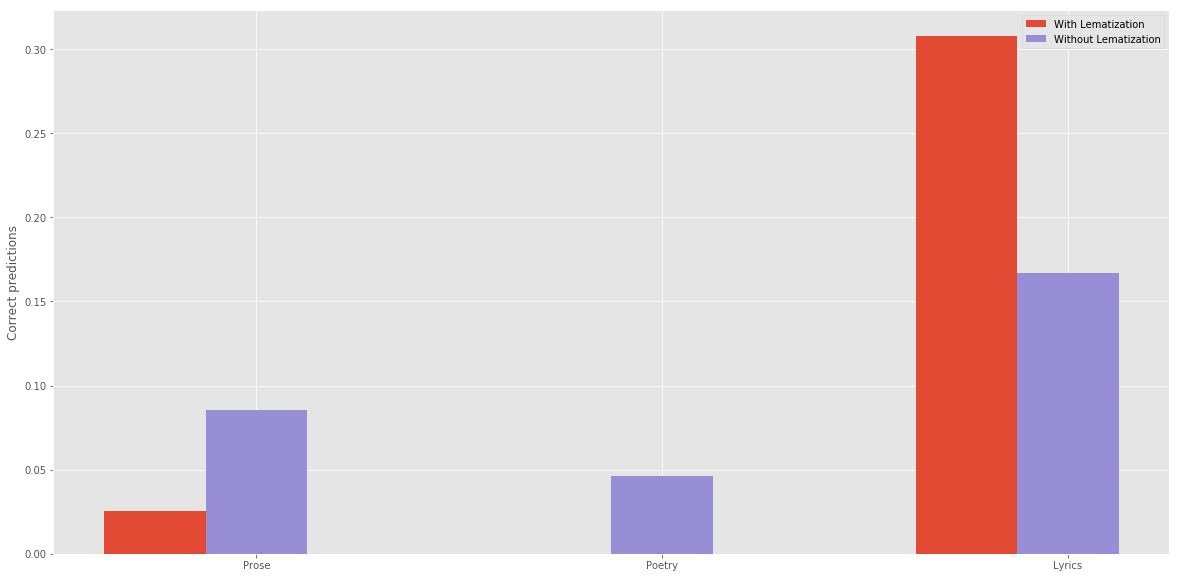

In [11]:
# Lematization
#    1. Yes
#    2. No

# Data to Analize
#    1. prose
#    2. poetry
#    3. lyrics

withLematization = []
withoutLematization = []
labels = ['Prose', 'Poetry', 'Lyrics']

for dataAnalize in range(1, 4):
    for isLematiozation in range(1, 3):
        
        positivePrediction, negativePrediction = main(isLematiozation, dataAnalize)
        score = positivePrediction / (positivePrediction + negativePrediction)

        if isLematiozation == 1:
            withLematization.append(score)
            print("{} with lematization:".format(labels[dataAnalize-1]))
        else:
            withoutLematization.append(score)
            print("{} without lematization:".format(labels[dataAnalize-1]))
       
        print("\tPositive predictions: {}\t".format(positivePrediction))
        print("\tNegative predictions: {}\t\n".format(negativePrediction))
        
plotStats(withLematization, withoutLematization, labels)